In [1]:
import pandas as pd
import numpy as np
import warnings
import os
from functools import reduce
warnings.filterwarnings(action='ignore')

import seaborn as sns

sns.set_palette("pastel")
import matplotlib.pylab as plt
from matplotlib import font_manager, rc
%matplotlib inline

sns.set(rc = {'figure.figsize':(15,7)})

import platform
your_os = platform.system()
if your_os == 'Linux':
    rc('font', family='NanumGothic')
elif your_os == 'Windows':
    ttf = "c:/Windows/Fonts/malgun.ttf"
    font_name = font_manager.FontProperties(fname=ttf).get_name()
    rc('font', family=font_name)
elif your_os == 'Darwin':
    rc('font', family='AppleGothic')
rc('axes', unicode_minus=False)

In [2]:
def get_season(x):
    season = ''
    if (x == 1) or (x == 2) or (x == 12):
        season = 'winter'
    elif (x == 3) or (x == 4) or (x == 5):
        season = 'spring'
    elif (x == 6) or (x == 7) or (x == 8):
        season = 'summer'
    elif (x == 9) or (x == 10) or (x == 11):
        season = 'fall'
    else:
        season = ''
    return season

**Notation**
- 연령대가 포함되어 있는 국내 유동인구와 음식물 쓰레기 배출량과의 관계 탐색 => 연령대를 묶었을 때 : 0+10(아동 청소년) / 20+30(청년) / 40+50(중년) / 60+70+80(장노년)
- 청년의 상관관계 쪽이 특징이 일관되며 두드러짐 (주거 지역에서 기간 상관없이 음의 상관관계가 우세, 그외거주 방문인구의 높은 상관관계 등)

In [3]:
waste = pd.read_csv('01_제공데이터/01_음식물쓰레기_FOOD_WASTE.CSV',encoding='cp949')
local = pd.read_pickle('01_제공데이터/02-1_내국인유동인구_KOREAN.pickle')

waste['base_date'] = pd.to_datetime(waste['base_date'])
waste['month'] = waste['base_date'].dt.month
waste['season'] = waste['month'].apply(lambda x: get_season(x)).astype('category')
local['base_date'] = pd.to_datetime(local['base_date'])
local['month'] = local['base_date'].dt.month
local['season'] = local['month'].apply(lambda x: get_season(x)).astype('category')

In [4]:
age_label = {0:'청소년', 10:'청소년', 20:'청년', 30:'청년', 40:'중년', 50:'중년', 60:'장노년', 70:'장노년', 80:'장노년'}
local['age_group'] = local[['age']].replace({'age':age_label})

In [5]:
waste.head()

,base_date,city,emd_cd,emd_nm,em_area_cd,em_cnt,em_g,pay_amt,month,season
0,2018-01-01,제주시,50110670,외도동,W6X062,2,15500,464,1,winter
1,2018-01-01,제주시,50110630,아라동,W6XA97,25,59800,1787,1,winter
2,2018-01-01,제주시,50110630,아라동,W6XA96,8,25350,758,1,winter
3,2018-01-01,제주시,50110630,아라동,W6XA95,12,30000,898,1,winter
4,2018-01-01,제주시,50110630,아라동,W6XA94,14,44050,1317,1,winter


In [6]:
local.head()

,base_date,time,city,emd_cd,emd_nm,sex,age,resd_pop_cnt,work_pop_cnt,visit_pop_cnt,resd,month,season,age_group
0,2018-01-01,1,제주시,50110250,한림읍,여성,0,638.5509,15.5400,151.5149,제주,1,winter,청소년
1,2018-01-01,1,제주시,50110250,한림읍,여성,0,0.0000,3.7249,171.3458,그외,1,winter,청소년
2,2018-01-01,1,제주시,50110250,한림읍,여성,10,668.4577,17.0308,166.0500,제주,1,winter,청소년
3,2018-01-01,1,제주시,50110250,한림읍,여성,10,0.0000,4.2577,195.8539,그외,1,winter,청소년
4,2018-01-01,1,제주시,50110250,한림읍,여성,20,609.7710,5.9490,148.7246,제주,1,winter,청년


# 전체

In [7]:
waste.groupby(['base_date'])['em_cnt','em_g','pay_amt'].sum().corr()

,em_cnt,em_g,pay_amt
em_cnt,1.000000,0.891084,0.867387
em_g,0.891084,1.000000,0.970358
pay_amt,0.867387,0.970358,1.000000


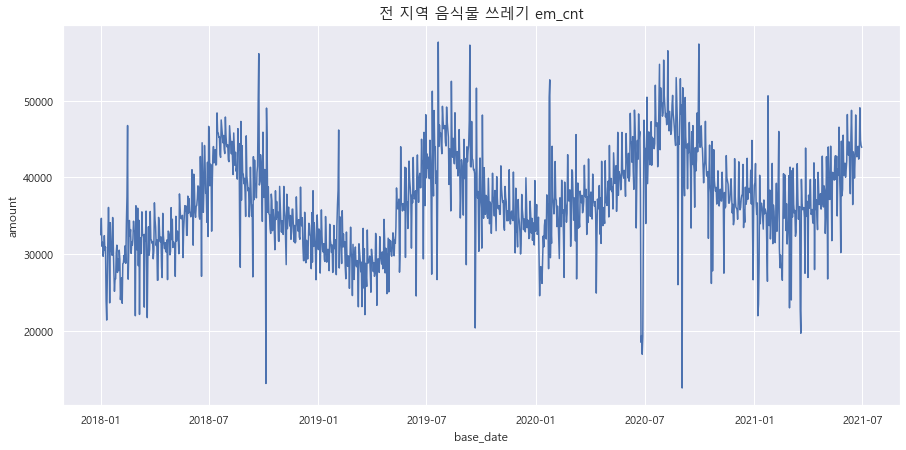

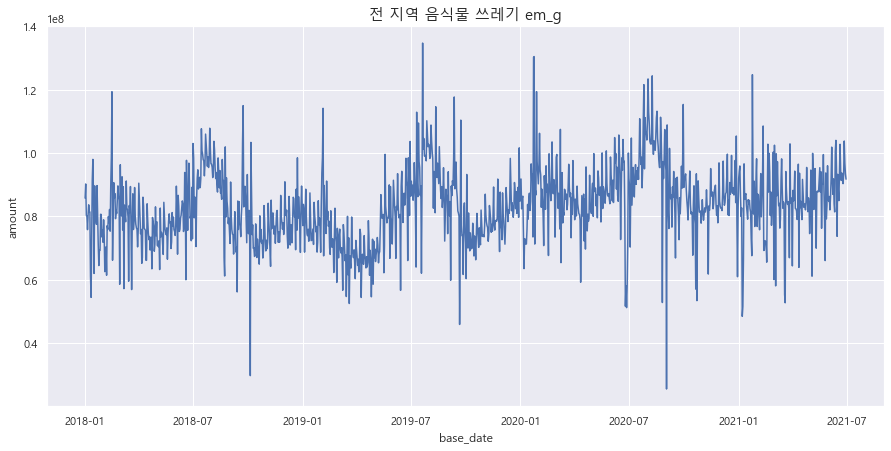

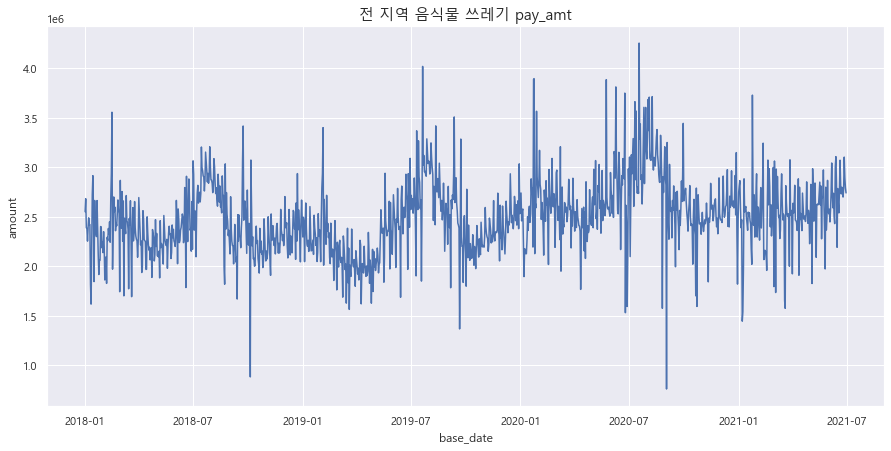

In [8]:
total_waste = waste.groupby(['base_date'])['em_cnt','em_g','pay_amt'].sum().stack().reset_index()
total_waste.columns = ['base_date','em','amount']

for em in total_waste['em'].unique():
    sns.lineplot(data=total_waste[total_waste['em'] == em],x='base_date',y='amount')
    plt.title('전 지역 음식물 쓰레기 {}'.format(em), fontsize=15)
    plt.show()

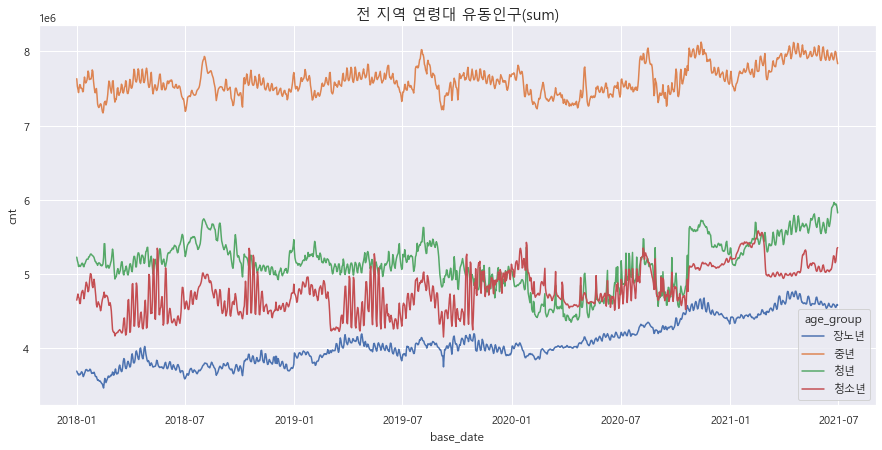

In [9]:
total_age = local.groupby(['base_date','age_group'])['resd_pop_cnt', 'work_pop_cnt', 'visit_pop_cnt'].sum().stack().reset_index()
total_age.columns = ['base_date','age_group','pop','cnt']
total_age = total_age.groupby(['base_date','age_group'])['cnt'].sum().reset_index()

sns.lineplot(data=total_age, x='base_date',y='cnt',hue='age_group')
plt.title('전 지역 연령대 유동인구(sum)', fontsize=15)
plt.show()

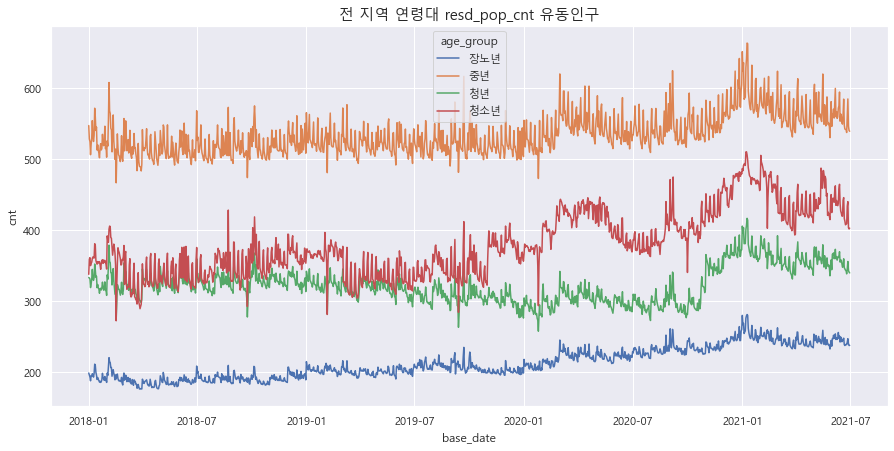

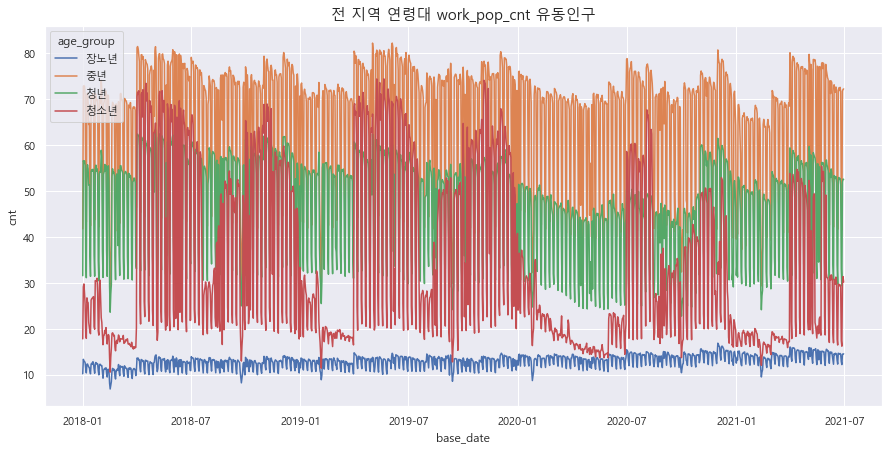

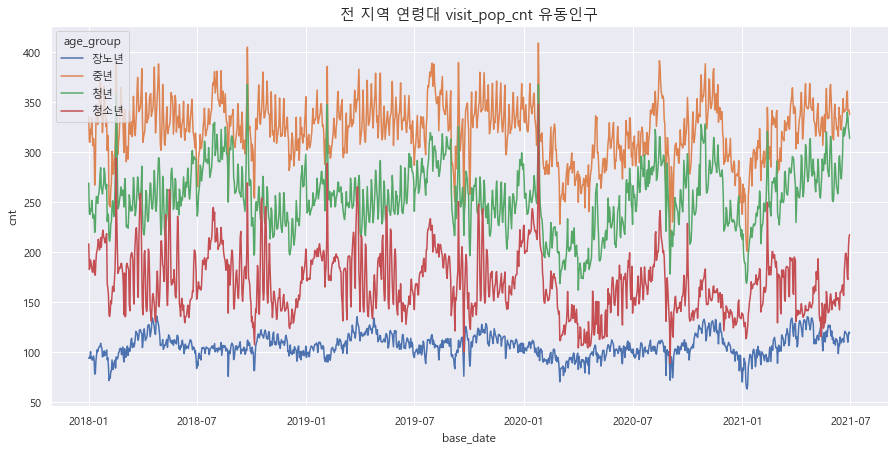

In [10]:
total_age = local.groupby(['base_date','age_group'])['resd_pop_cnt', 'work_pop_cnt', 'visit_pop_cnt'].mean().stack().reset_index()
total_age.columns = ['base_date','age_group','pop','cnt']

for pop in total_age['pop'].unique():
    sns.lineplot(data=total_age[total_age['pop'] == pop], x='base_date',y='cnt',hue='age_group')
    plt.title('전 지역 연령대 {} 유동인구'.format(pop), fontsize=15)
    plt.show()

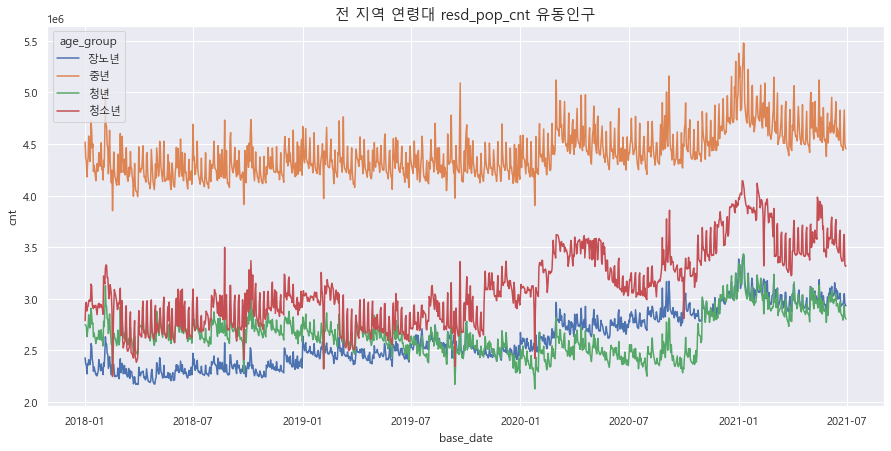

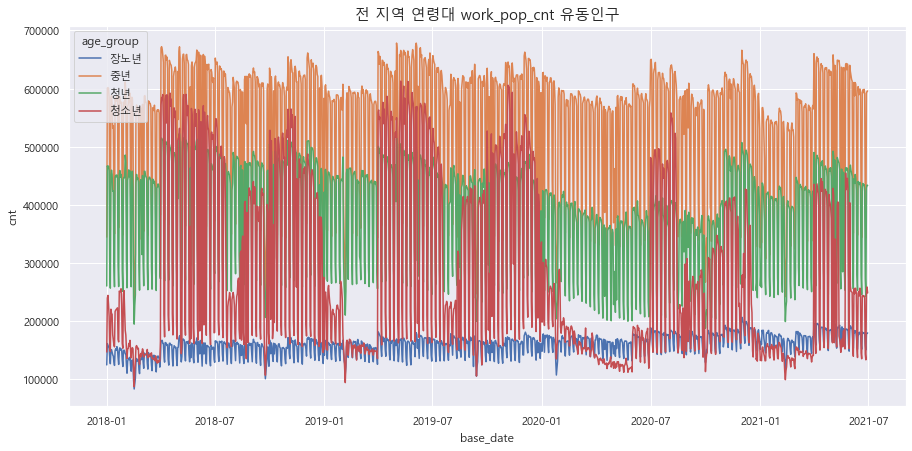

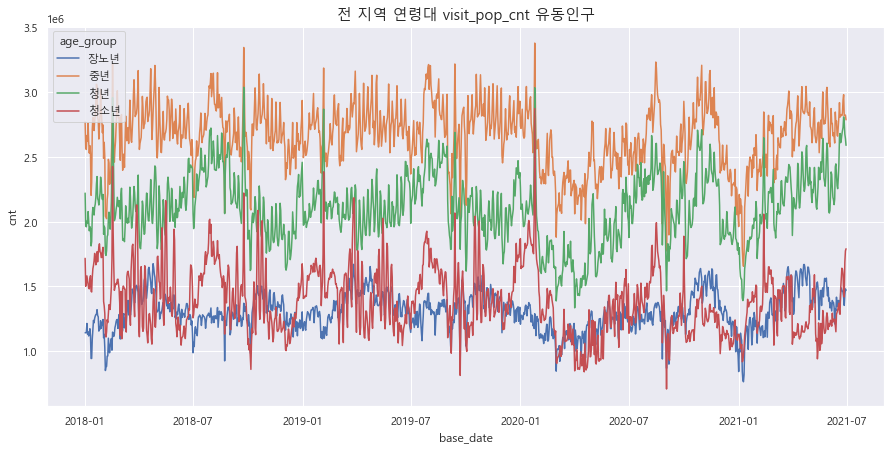

In [11]:
total_age = local.groupby(['base_date','age_group'])['resd_pop_cnt', 'work_pop_cnt', 'visit_pop_cnt'].sum().stack().reset_index()
total_age.columns = ['base_date','age_group','pop','cnt']

for pop in total_age['pop'].unique():
    sns.lineplot(data=total_age[total_age['pop'] == pop], x='base_date',y='cnt',hue='age_group')
    plt.title('전 지역 연령대 {} 유동인구'.format(pop), fontsize=15)
    plt.show()

# 쓰레기 배출량
- 일별은 상관계수가 매우 낮음
- 월별과 계절별로 나누어 진행

## 월별
- 모든 인구 : 청년에서 양의 상관관계(0.6), 장노년에서 음의 상관관계(-0.65)
- 거주인구 : 청년(-0.6)과 중년(-0.67)에서 음의 상관관계
- 근무인구 : 낮음 -> 그나마 청년에서 약간의 음의 상관관계(-0.2)
- 방문인구
(전체) 청년(0.9)과 청소년(0.6)에서 양의 상관관계, (제주) 청년에서 음의 상관관계(-0.52), (그외) 청년에서 양의 상관관계(0.9)

<AxesSubplot:>

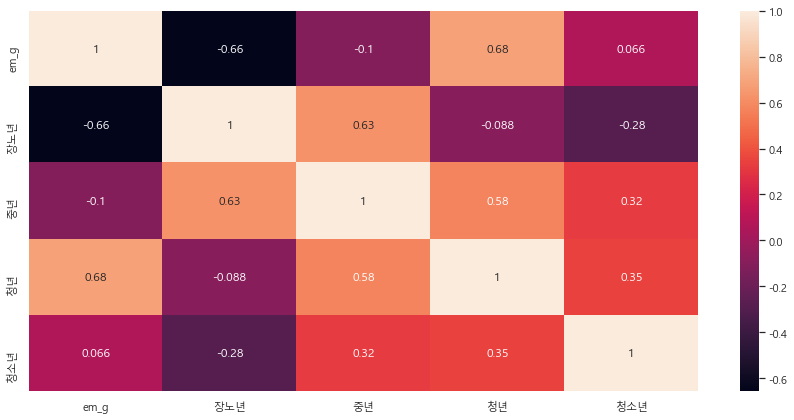

In [12]:
# 쓰레기 배출량과 (새로 정의한) 연령대별 모든 종류의 유동인구 간 상관관계

emg_waste = waste.groupby(['month'])['em_g'].mean().reset_index() # 월평균 쓰레기 배출량
total_age = local.groupby(['month','age_group'])['resd_pop_cnt','visit_pop_cnt','work_pop_cnt'].mean().stack().reset_index() # 월평균 모든 종류의 유동인구
total_age.columns = ['month','age_group','pop','cnt']

total_age = total_age.pivot_table(index='month',columns = 'age_group',values='cnt', aggfunc='sum').reset_index()

sns.heatmap(pd.merge(emg_waste, total_age, on='month',how='left').set_index('month').corr(),annot=True)

<AxesSubplot:>

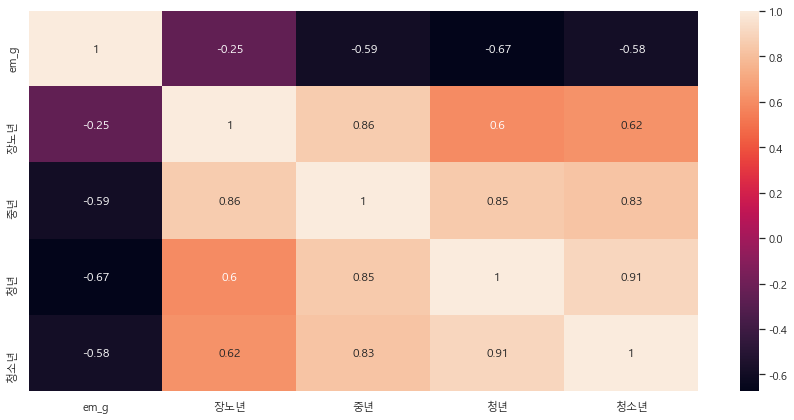

In [13]:
# 쓰레기 배출량과 연령대별 거주 인구 간 상관관계

emg_waste = waste.groupby(['month'])['em_g'].mean().reset_index() # 월평균 쓰레기 배출량
total_age = local.groupby(['month','age_group'])['resd_pop_cnt'].mean().reset_index() # 월평균 모든 종류의 유동인구
#total_age.columns = ['month','age_group','pop','cnt']

total_age = total_age.pivot_table(index='month',columns = 'age_group',values='resd_pop_cnt').reset_index()
sns.heatmap(pd.merge(emg_waste, total_age, on='month',how='left').set_index('month').corr(),annot=True)

<AxesSubplot:>

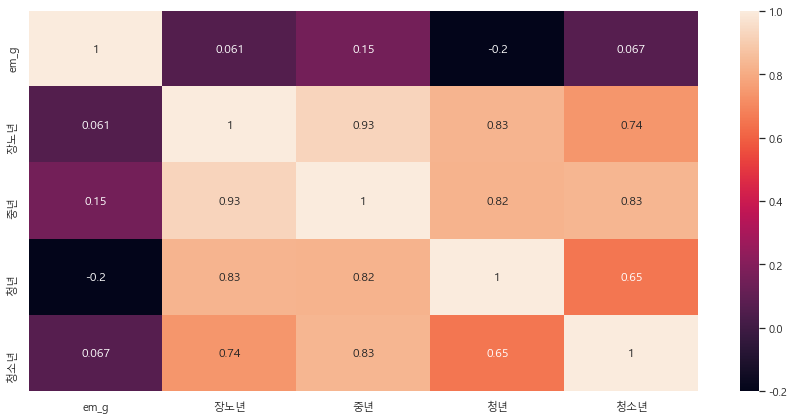

In [14]:
# 쓰레기 배출량과 연령대별 근무 인구 간 상관관계
emg_waste = waste.groupby(['month'])['em_g'].mean().reset_index() # 월평균 쓰레기 배출량
total_age = local.groupby(['month','age_group'])['work_pop_cnt'].mean().reset_index() # 월평균 모든 종류의 유동인구
#total_age.columns = ['month','age_group','pop','cnt']

total_age = total_age.pivot_table(index='month',columns = 'age_group',values='work_pop_cnt').reset_index()
sns.heatmap(pd.merge(emg_waste, total_age, on='month',how='left').set_index('month').corr(),annot=True)

<AxesSubplot:>

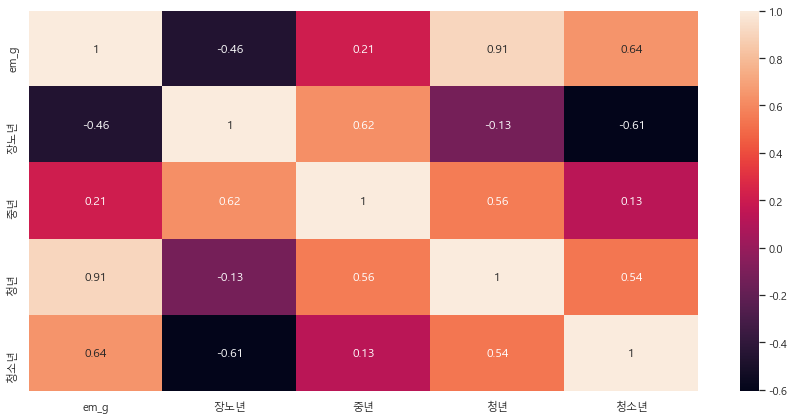

In [15]:
# 쓰레기 배출량과 연령대별 방문 인구 간 상관관계
emg_waste = waste.groupby(['month'])['em_g'].mean().reset_index() # 월평균 쓰레기 배출량
total_age = local.groupby(['month','age_group'])['visit_pop_cnt'].mean().reset_index() # 월평균 모든 종류의 유동인구
#total_age.columns = ['month','age_group','pop','cnt']

total_age = total_age.pivot_table(index='month',columns = 'age_group',values='visit_pop_cnt').reset_index()
sns.heatmap(pd.merge(emg_waste, total_age, on='month',how='left').set_index('month').corr(),annot=True)

<AxesSubplot:>

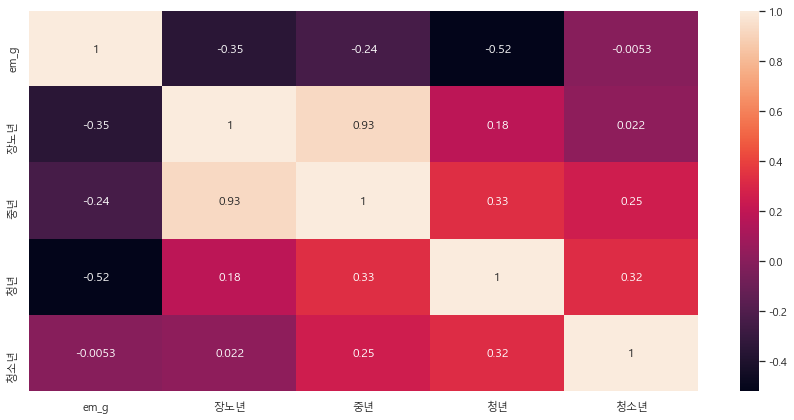

In [16]:
# 쓰레기 배출량과 연령대별 방문 인구(제주 거주) 간 상관관계
emg_waste = waste.groupby(['month'])['em_g'].mean().reset_index() # 월평균 쓰레기 배출량
total_age = local[local['resd'] == '제주'].groupby(['month','age_group'])['visit_pop_cnt'].mean().reset_index() # 월평균 모든 종류의 유동인구
#total_age.columns = ['month','age_group','pop','cnt']

total_age = total_age.pivot_table(index='month',columns = 'age_group',values='visit_pop_cnt').reset_index()
sns.heatmap(pd.merge(emg_waste, total_age, on='month',how='left').set_index('month').corr(),annot=True)

<AxesSubplot:>

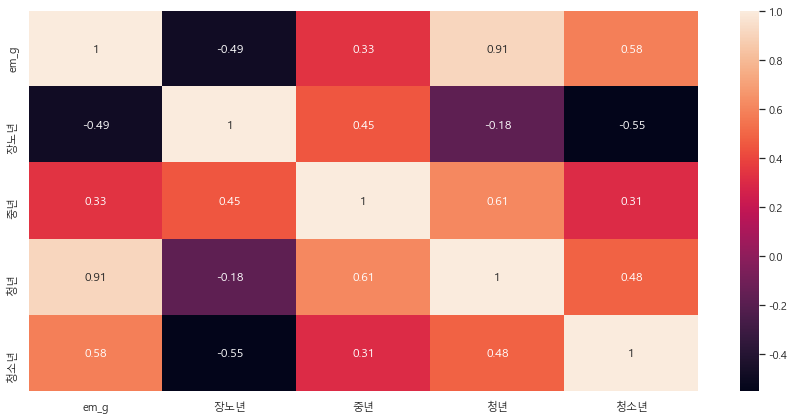

In [17]:
# 쓰레기 배출량과 연령대별 방문 인구(그외 거주) 간 상관관계
emg_waste = waste.groupby(['month'])['em_g'].mean().reset_index() # 월평균 쓰레기 배출량
total_age = local[local['resd'] == '그외'].groupby(['month','age_group'])['visit_pop_cnt'].mean().reset_index() # 월평균 모든 종류의 유동인구
#total_age.columns = ['month','age_group','pop','cnt']

total_age = total_age.pivot_table(index='month',columns = 'age_group',values='visit_pop_cnt').reset_index()
sns.heatmap(pd.merge(emg_waste, total_age, on='month',how='left').set_index('month').corr(),annot=True)

## 계절별
- 모든 인구 : 청년에서 양의 상관관계(0.97), 장노년에서 음의 상관관계(-0.5)
- 거주인구 : 청소년(-0.56), 청년(-0.6)과 중년(-0.54)에서 음의 상관관계
- 근무인구 : 장노년(0.73)과 중년(0.55)에서 양의 상관관계
- 방문인구
(전체) 청년(0.9)과 청소년(0.6)에서 양의 상관관계, (제주) 청년에서 음의 상관관계(-0.52), (그외) 청년에서 양의 상관관계(0.9)

<AxesSubplot:>

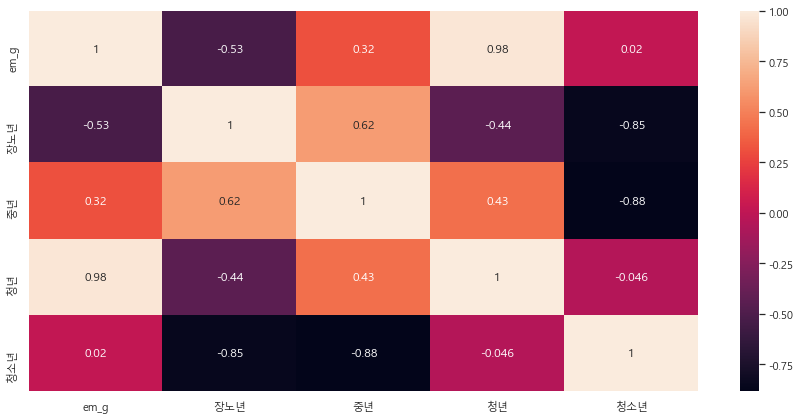

In [18]:
# 쓰레기 배출량과 (새로 정의한) 연령대별 모든 종류의 유동인구 간 상관관계

emg_waste = waste.groupby(['season'])['em_g'].mean().reset_index() # 계절평균 쓰레기 배출량
total_age = local.groupby(['season','age_group'])['resd_pop_cnt','visit_pop_cnt','work_pop_cnt'].mean().stack().reset_index() # 계절평균 모든 종류의 유동인구
total_age.columns = ['season','age_group','pop','cnt']

total_age = total_age.pivot_table(index='season',columns = 'age_group',values='cnt', aggfunc='sum').reset_index()

sns.heatmap(pd.merge(emg_waste, total_age, on='season',how='left').set_index('season').corr(),annot=True)

<AxesSubplot:>

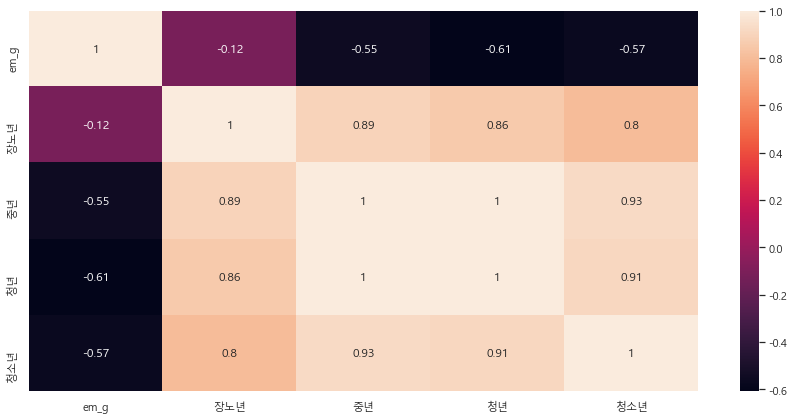

In [19]:
# 쓰레기 배출량과 연령대별 거주 인구 간 상관관계

emg_waste = waste.groupby(['season'])['em_g'].mean().reset_index() # 계절평균 쓰레기 배출량
total_age = local.groupby(['season','age_group'])['resd_pop_cnt'].mean().reset_index() # 계절평균 거주인구
#total_age.columns = ['month','age_group','pop','cnt']

total_age = total_age.pivot_table(index='season',columns = 'age_group',values='resd_pop_cnt').reset_index()
sns.heatmap(pd.merge(emg_waste, total_age, on='season',how='left').set_index('season').corr(),annot=True)

<AxesSubplot:>

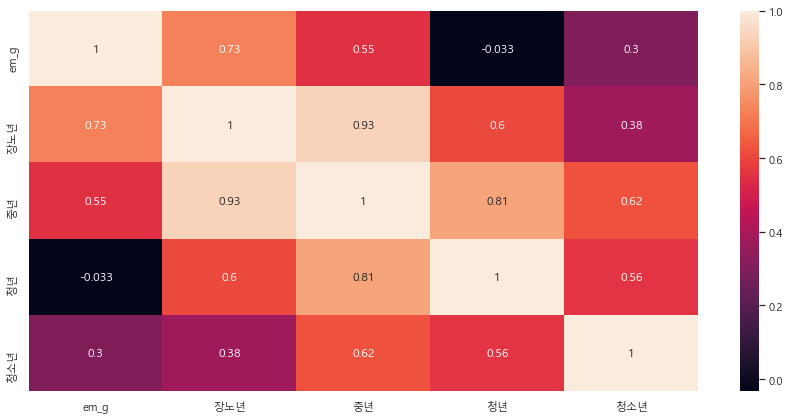

In [20]:
# 쓰레기 배출량과 연령대별 근무 인구 간 상관관계
emg_waste = waste.groupby(['season'])['em_g'].mean().reset_index() # 계절평균 쓰레기 배출량
total_age = local.groupby(['season','age_group'])['work_pop_cnt'].mean().reset_index() # 계절평균 근무인구
#total_age.columns = ['month','age_group','pop','cnt']

total_age = total_age.pivot_table(index='season',columns = 'age_group',values='work_pop_cnt').reset_index()
sns.heatmap(pd.merge(emg_waste, total_age, on='season',how='left').set_index('season').corr(),annot=True)

<AxesSubplot:>

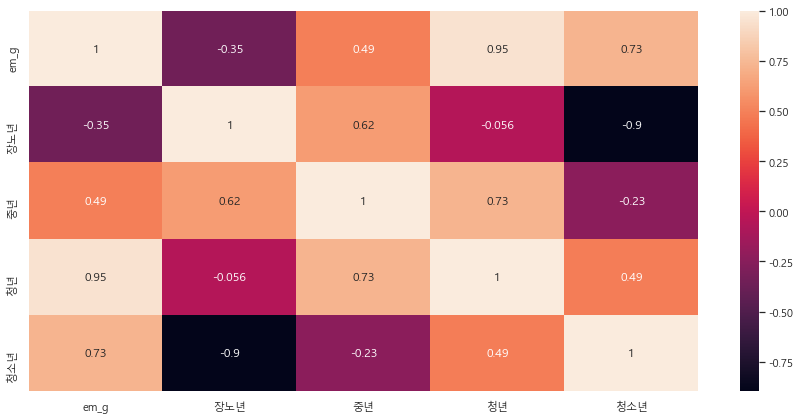

In [21]:
# 쓰레기 배출량과 연령대별 방문 인구 간 상관관계
emg_waste = waste.groupby(['season'])['em_g'].mean().reset_index() # 계절평균 쓰레기 배출량
total_age = local.groupby(['season','age_group'])['visit_pop_cnt'].mean().reset_index() # 계절평균 제주 거주 방문인구
#total_age.columns = ['month','age_group','pop','cnt']

total_age = total_age.pivot_table(index='season',columns = 'age_group',values='visit_pop_cnt').reset_index()
sns.heatmap(pd.merge(emg_waste, total_age, on='season',how='left').set_index('season').corr(),annot=True)

<AxesSubplot:>

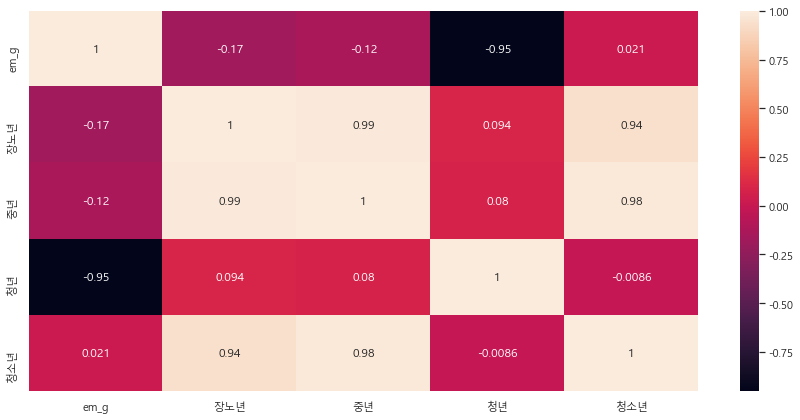

In [22]:
# 쓰레기 배출량과 연령대별 방문 인구(제주 거주) 간 상관관계
emg_waste = waste.groupby(['season'])['em_g'].mean().reset_index() # 계절평균 쓰레기 배출량
total_age = local[local['resd'] == '제주'].groupby(['season','age_group'])['visit_pop_cnt'].mean().reset_index() # 계절평균 제주 거주 방문인구
#total_age.columns = ['month','age_group','pop','cnt']

total_age = total_age.pivot_table(index='season',columns = 'age_group',values='visit_pop_cnt').reset_index()
sns.heatmap(pd.merge(emg_waste, total_age, on='season',how='left').set_index('season').corr(),annot=True)

<AxesSubplot:>

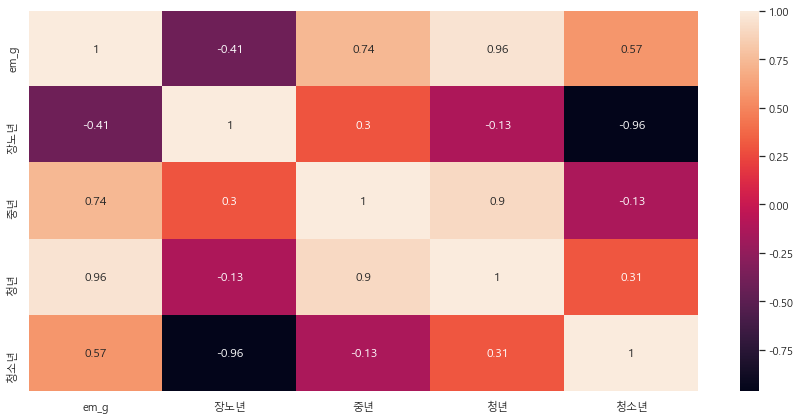

In [23]:
# 쓰레기 배출량과 연령대별 방문 인구(그외 거주) 간 상관관계
emg_waste = waste.groupby(['season'])['em_g'].mean().reset_index() # 계절평균 쓰레기 배출량
total_age = local[local['resd'] == '그외'].groupby(['season','age_group'])['visit_pop_cnt'].mean().reset_index() # 계절평균 그외 거주 방문인구
#total_age.columns = ['month','age_group','pop','cnt']

total_age = total_age.pivot_table(index='season',columns = 'age_group',values='visit_pop_cnt').reset_index()
sns.heatmap(pd.merge(emg_waste, total_age, on='season',how='left').set_index('season').corr(),annot=True)

# 쓰레기 배출건수
- 일별은 상관계수가 매우 낮기 때문에 월별로 확인

## 월별 쓰레기 배출건수
- 모든 인구 : 청년에서 양의 상관관계(0.53), 나머지는 관련성이 미미함
- 거주인구 : 중년, 청년, 청소년에서 거의 음의 상관관계(-0.8대), 장노년(-0.55)
- 근무인구 : 관련성 미미함
- 방문인구
(전체) 청년(0.9)에서 양의 상관관계, (제주) 청년에서 음의 상관관계(-0.56), (그외) 청년에서 양의 상관관계(0.91)

<AxesSubplot:>

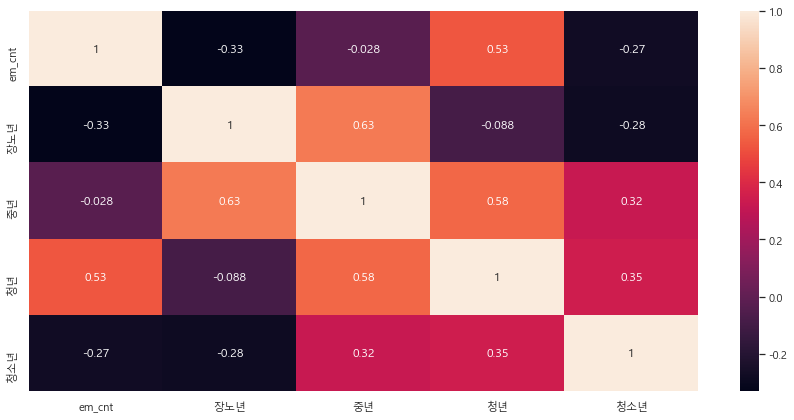

In [24]:
# 쓰레기 배출건수와 (새로 정의한) 연령대별 모든 종류의 유동인구 간 상관관계
emc_waste = waste.groupby(['month'])['em_cnt'].mean().reset_index() # 월평균 쓰레기 배출량
total_age = local.groupby(['month','age_group'])['resd_pop_cnt','visit_pop_cnt','work_pop_cnt'].mean().stack().reset_index() # 월평균 모든 종류의 유동인구
total_age.columns = ['month','age_group','pop','cnt']

total_age = total_age.pivot_table(index='month',columns = 'age_group',values='cnt', aggfunc='sum').reset_index()

sns.heatmap(pd.merge(emc_waste, total_age, on='month',how='left').set_index('month').corr(),annot=True)

<AxesSubplot:>

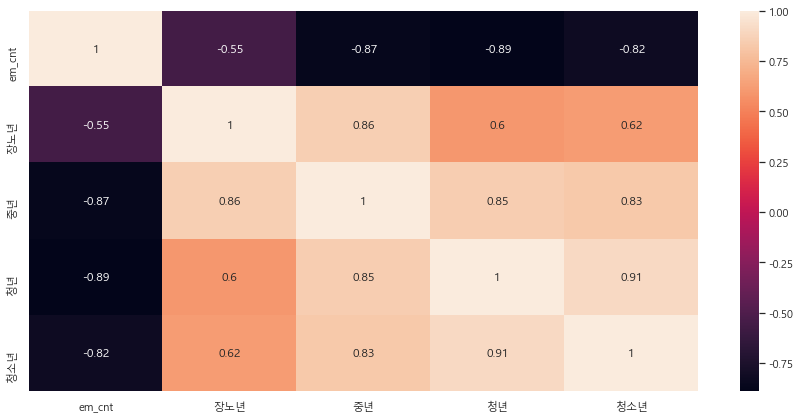

In [25]:
# 쓰레기 배출건수와 연령대별 거주인구 간 상관관계
emc_waste = waste.groupby(['month'])['em_cnt'].mean().reset_index() # 월평균 쓰레기 배출건수
total_age = local.groupby(['month','age_group'])['resd_pop_cnt'].mean().reset_index() # 월평균 거주인구
#total_age.columns = ['month','age_group','pop','cnt']

total_age = total_age.pivot_table(index='month',columns = 'age_group',values='resd_pop_cnt').reset_index()
sns.heatmap(pd.merge(emc_waste, total_age, on='month',how='left').set_index('month').corr(),annot=True)

<AxesSubplot:>

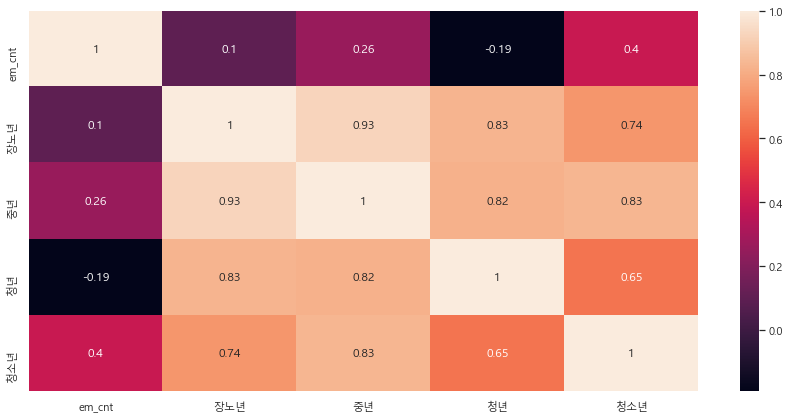

In [26]:
# 쓰레기 배출건수와 연령대별 근무인구 간 상관관계
emc_waste = waste.groupby(['month'])['em_cnt'].mean().reset_index() # 월평균 쓰레기 배출건수
total_age = local.groupby(['month','age_group'])['work_pop_cnt'].mean().reset_index() # 월평균 근무인구
#total_age.columns = ['month','age_group','pop','cnt']

total_age = total_age.pivot_table(index='month',columns = 'age_group',values='work_pop_cnt').reset_index()
sns.heatmap(pd.merge(emc_waste, total_age, on='month',how='left').set_index('month').corr(),annot=True)

<AxesSubplot:>

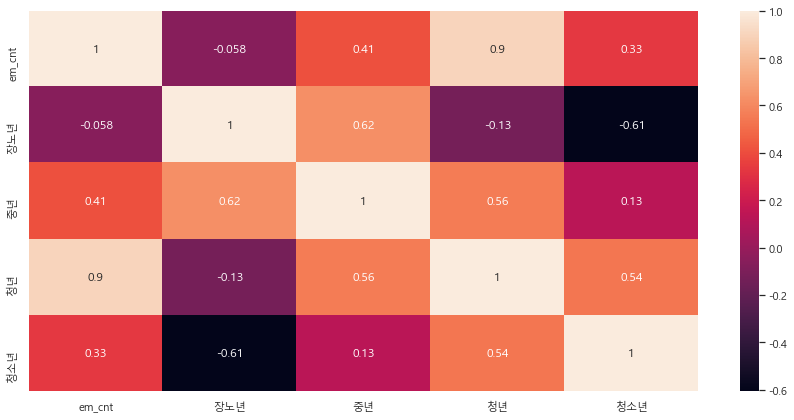

In [27]:
# 쓰레기 배출건수와 연령대별 방문인구 간 상관관계
emc_waste = waste.groupby(['month'])['em_cnt'].mean().reset_index() # 월평균 쓰레기 배출건수
total_age = local.groupby(['month','age_group'])['visit_pop_cnt'].mean().reset_index() # 월평균 방문인구
#total_age.columns = ['month','age_group','pop','cnt']

total_age = total_age.pivot_table(index='month',columns = 'age_group',values='visit_pop_cnt').reset_index()
sns.heatmap(pd.merge(emc_waste, total_age, on='month',how='left').set_index('month').corr(),annot=True)

<AxesSubplot:>

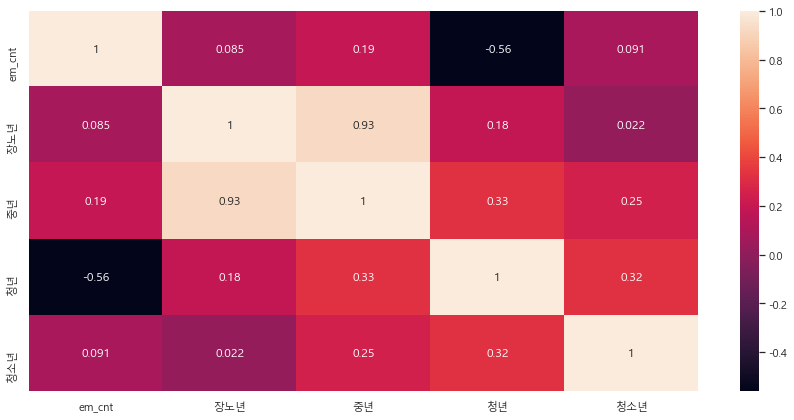

In [28]:
# 쓰레기 배출건수와 연령대별 방문 인구(제주 거주) 간 상관관계
emc_waste = waste.groupby(['month'])['em_cnt'].mean().reset_index() # 월평균 쓰레기 배출건수
total_age = local[local['resd'] == '제주'].groupby(['month','age_group'])['visit_pop_cnt'].mean().reset_index() # 월평균 제주 거주 방문인구
#total_age.columns = ['month','age_group','pop','cnt']

total_age = total_age.pivot_table(index='month',columns = 'age_group',values='visit_pop_cnt').reset_index()
sns.heatmap(pd.merge(emc_waste, total_age, on='month',how='left').set_index('month').corr(),annot=True)

<AxesSubplot:>

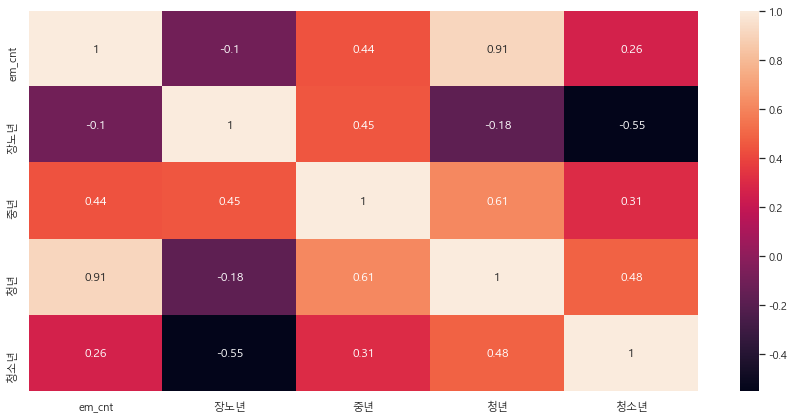

In [29]:
# 쓰레기 배출건수와 연령대별 방문 인구(그외 거주) 간 상관관계
emc_waste = waste.groupby(['month'])['em_cnt'].mean().reset_index() # 월평균 쓰레기 배출건수
total_age = local[local['resd'] == '그외'].groupby(['month','age_group'])['visit_pop_cnt'].mean().reset_index() # 월평균 그외 거주 방문인구
#total_age.columns = ['month','age_group','pop','cnt']

total_age = total_age.pivot_table(index='month',columns = 'age_group',values='visit_pop_cnt').reset_index()
sns.heatmap(pd.merge(emc_waste, total_age, on='month',how='left').set_index('month').corr(),annot=True)

## 계절별 쓰레기 배출건수
- 모든 인구 : 청년(0.75), 중년(0.56)에서 양의 상관관계
- 거주인구 : 청소년(-0.89), 청년(-0.96)과 중년(-0.93)에서 음의 상관관계, 장노년(-0.68) 또한 어느 정도 음의 상관관계
- 근무인구 : 장노년(0.68)과 중년(0.72), 청소년(0.8)에서 양의 상관관계
- 방문인구
(전체) 청년(0.94)과 중년(0.89)에서 양의 상관관계, (제주) 청년(-0.75)과 청소년(-0.6)에서 음의 상관관계,  (그외) 청년(0.93)과 중년(0.98)에서 양의 상관관계

<AxesSubplot:>

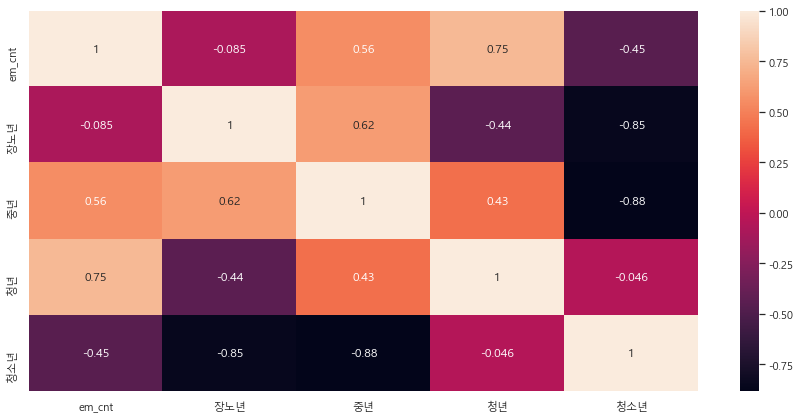

In [30]:
# 쓰레기 배출건수와 (새로 정의한) 연령대별 모든 종류의 유동인구 간 상관관계
emc_waste = waste.groupby(['season'])['em_cnt'].mean().reset_index() # 계절평균 쓰레기 배출량
total_age = local.groupby(['season','age_group'])['resd_pop_cnt','visit_pop_cnt','work_pop_cnt'].mean().stack().reset_index() # 계절평균 모든 종류의 유동인구
total_age.columns = ['season','age_group','pop','cnt']

total_age = total_age.pivot_table(index='season',columns = 'age_group',values='cnt', aggfunc='sum').reset_index()

sns.heatmap(pd.merge(emc_waste, total_age, on='season',how='left').set_index('season').corr(),annot=True)

<AxesSubplot:>

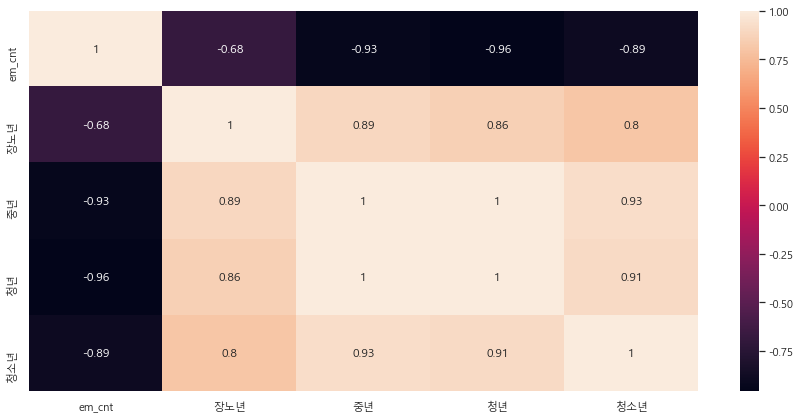

In [31]:
# 쓰레기 배출건수와 연령대별 거주인구 간 상관관계
emc_waste = waste.groupby(['season'])['em_cnt'].mean().reset_index() # 계절평균 쓰레기 배출건수
total_age = local.groupby(['season','age_group'])['resd_pop_cnt'].mean().reset_index() # 계절평균 거주인구
#total_age.columns = ['month','age_group','pop','cnt']

total_age = total_age.pivot_table(index='season',columns = 'age_group',values='resd_pop_cnt').reset_index()
sns.heatmap(pd.merge(emc_waste, total_age, on='season',how='left').set_index('season').corr(),annot=True)

<AxesSubplot:>

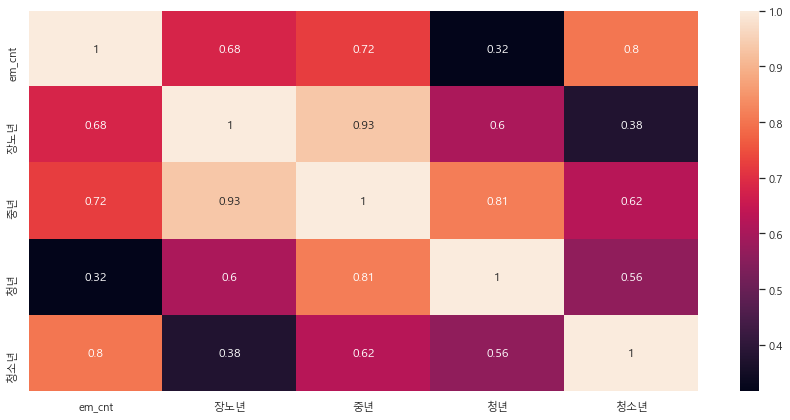

In [32]:
# 쓰레기 배출건수와 연령대별 근무인구 간 상관관계
emc_waste = waste.groupby(['season'])['em_cnt'].mean().reset_index() # 계절평균 쓰레기 배출건수
total_age = local.groupby(['season','age_group'])['work_pop_cnt'].mean().reset_index() # 계절평균 근무인구
#total_age.columns = ['month','age_group','pop','cnt']

total_age = total_age.pivot_table(index='season',columns = 'age_group',values='work_pop_cnt').reset_index()
sns.heatmap(pd.merge(emc_waste, total_age, on='season',how='left').set_index('season').corr(),annot=True)

<AxesSubplot:>

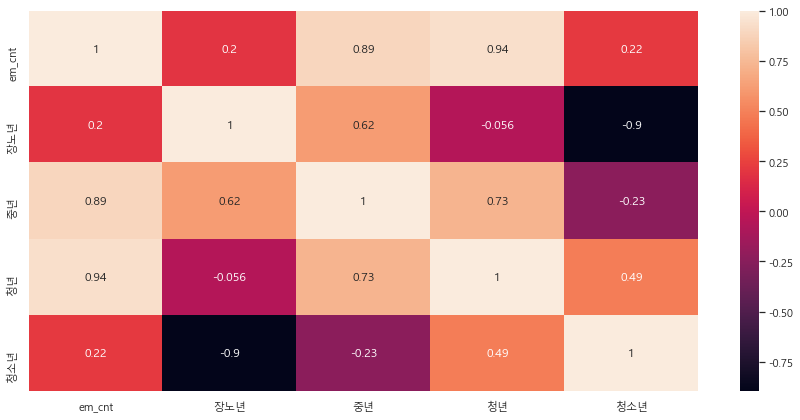

In [33]:
# 쓰레기 배출건수와 연령대별 방문인구 간 상관관계
emc_waste = waste.groupby(['season'])['em_cnt'].mean().reset_index() # 계절평균 쓰레기 배출건수
total_age = local.groupby(['season','age_group'])['visit_pop_cnt'].mean().reset_index() # 계절평균 방문인구
#total_age.columns = ['month','age_group','pop','cnt']

total_age = total_age.pivot_table(index='season',columns = 'age_group',values='visit_pop_cnt').reset_index()
sns.heatmap(pd.merge(emc_waste, total_age, on='season',how='left').set_index('season').corr(),annot=True)

<AxesSubplot:>

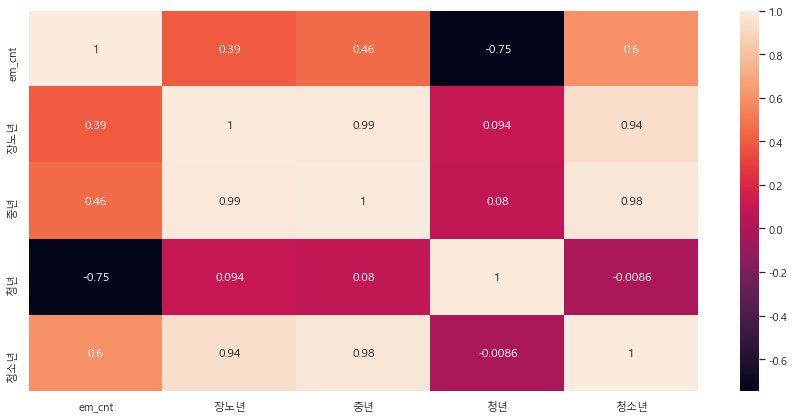

In [34]:
# 쓰레기 배출건수와 연령대별 방문 인구(제주 거주) 간 상관관계
emc_waste = waste.groupby(['season'])['em_cnt'].mean().reset_index() # 계절평균 쓰레기 배출건수
total_age = local[local['resd'] == '제주'].groupby(['season','age_group'])['visit_pop_cnt'].mean().reset_index() # 계절평균 제주 거주 방문인구
#total_age.columns = ['month','age_group','pop','cnt']

total_age = total_age.pivot_table(index='season',columns = 'age_group',values='visit_pop_cnt').reset_index()
sns.heatmap(pd.merge(emc_waste, total_age, on='season',how='left').set_index('season').corr(),annot=True)

<AxesSubplot:>

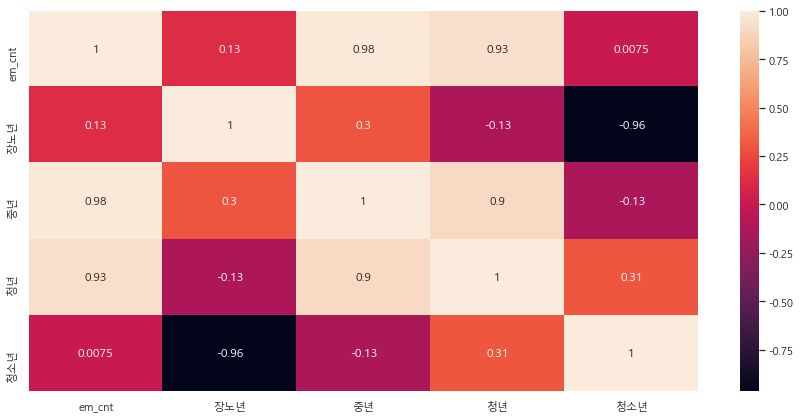

In [35]:
# 쓰레기 배출건수와 연령대별 방문 인구(그외 거주) 간 상관관계
emc_waste = waste.groupby(['season'])['em_cnt'].mean().reset_index() # 계절평균 쓰레기 배출건수
total_age = local[local['resd'] == '그외'].groupby(['season','age_group'])['visit_pop_cnt'].mean().reset_index() # 계절평균 그외 거주 방문인구
#total_age.columns = ['month','age_group','pop','cnt']

total_age = total_age.pivot_table(index='season',columns = 'age_group',values='visit_pop_cnt').reset_index()
sns.heatmap(pd.merge(emc_waste, total_age, on='season',how='left').set_index('season').corr(),annot=True)